# Natural language analysis

First, the previously prepared dataset is downloaded and parsed into a dataframe.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import os
import nltk
from nltk import word_tokenize
from tqdm.auto import tqdm
import shutil

dataset_path = Path('issues.csv.gz')

# download dataset if not already present
if not dataset_path.exists():
    import requests

    with requests.get('https://vps-cd52fe2c.vps.ovh.net/nlp/issues.csv.gz', stream=True) as r:
        content_length = int(r.headers.get("Content-Length"))

        with tqdm.wrapattr(r.raw, 'read', total=content_length, desc='Downloading dataset') as raw:
            with open(dataset_path, 'wb') as f:
                shutil.copyfileobj(raw, f)

df = pd.read_csv(dataset_path, keep_default_na=False)
LANGUAGES = df['language'].unique()


We will be operating on 4 classes defined by the programming language.

In [2]:
print(LANGUAGES)
df.sample(n=10)


['Python' 'C' 'Javascript' 'Go']


,author,language,text
156628,aybabtme,Go,The duration of a turn is given in the JSON re...
13598,ericmjl,Python,@mwaskom referencing re: ECDFs; I have a simpl...
43136,taviso,C,"I'm trying to use the console application , it..."
154771,elithrar,Go,"Web.go has been fantastic, but one thing I mis..."
156114,ebuchman,Go,Serialization issues have been a constant plag...
109761,mmistakes,Javascript,Page displaying this bug
16415,merveenoyan,Python,I want to use pre-trained embeddings of spaCy ...
70283,daniel-koehn,C,There are still some issues related to the gra...
18706,dfm,Python,This could be huge!
58773,guidovranken,C,I've written a libFuzzer-based fuzzer for Ethe...


We begin by tokenizing the normalizing the raw text from issues.

In [3]:
df['tokenized_text'] = df['text'].apply(word_tokenize)
df.head()


,author,language,text,tokenized_text
0,llSourcell,Python,I get the following error when i attempt to tr...,"[I, get, the, following, error, when, i, attem..."
1,llSourcell,Python,won't compile. output below bash-3.2# make Mak...,"[wo, n't, compile, ., output, below, bash-3.2,..."
2,llSourcell,Python,I get this error when i attemp to build the co...,"[I, get, this, error, when, i, attemp, to, bui..."
3,llSourcell,Python,i couldn't find an instance on AWS called 'ami...,"[i, could, n't, find, an, instance, on, AWS, c..."
4,llSourcell,Python,Error below. Any ideas? dyn-160-39-195-144:wal...,"[Error, below, ., Any, ideas, ?, dyn-160-39-19..."


In [4]:
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
sw = set(stopwords.words('english'))


def normalize_words(words: list[str]) -> list[str]:
    tokens = (
        # Make all words lowercase
        word.lower()
        for word in words
        # Remove punctuations
        if word.isalpha())
    # Remove stopwords
    tokens = [word for word in tokens if not word in sw]

    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcinwojnarowski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df['normalized_text'] = df['tokenized_text'].apply(normalize_words)
df.head()

,author,language,text,tokenized_text,normalized_text
0,llSourcell,Python,I get the following error when i attempt to tr...,"[I, get, the, following, error, when, i, attem...","[get, following, error, attempt, train, networ..."
1,llSourcell,Python,won't compile. output below bash-3.2# make Mak...,"[wo, n't, compile, ., output, below, bash-3.2,...","[wo, compile, output, make, making, src, makin..."
2,llSourcell,Python,I get this error when i attemp to build the co...,"[I, get, this, error, when, i, attemp, to, bui...","[get, error, attemp, build, code, ideas]"
3,llSourcell,Python,i couldn't find an instance on AWS called 'ami...,"[i, could, n't, find, an, instance, on, AWS, c...","[could, find, instance, aws, called, link, one]"
4,llSourcell,Python,Error below. Any ideas? dyn-160-39-195-144:wal...,"[Error, below, ., Any, ideas, ?, dyn-160-39-19...","[error, ideas, jasonravel, build, failure, bui..."


## Basic analysis

Next, we proceed with a series of basic analysis of individual languages and note the differences.

### Average text length

What is the average length (in the amount of words) of an issue?

Here, nothing interesting is noticed.

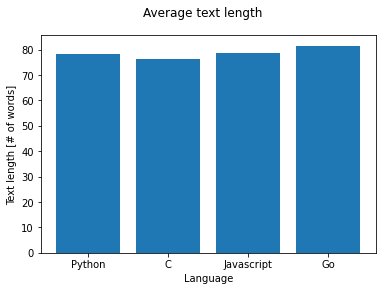

In [142]:
df['length'] = df['tokenized_text'].apply(len)

means = [np.mean(df[df['language'] == lang]['length']) for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.xlabel("Language")
plt.ylabel("Text length [# of words]")
plt.suptitle("Average text length")
plt.show()


### Average lexical diversity

How diverse is the vocabulary of a single entry?

Again, on a local scale no difference can be observed.

In [133]:
def lexical_diversity(text: list[str]) -> float:
    if len(text) == 0:
        return 1
    return len(set(text)) / len(text)


df['lex_div'] = df['normalized_text'].apply(lexical_diversity)

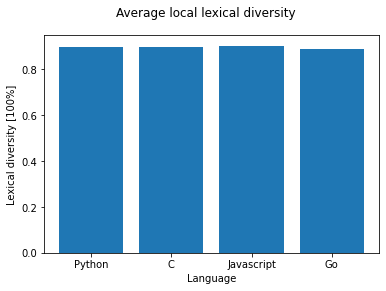

In [143]:
means = [np.mean(df[df['language'] == lang]['lex_div']) for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.xlabel("Language")
plt.ylabel("Lexical diversity [100%]")
plt.suptitle("Average local lexical diversity")
plt.show()


### Total lexical diversity

How diverse is the vocabulary over all texts grouped by language?

Here, C shows an almost 1.5% greater lexical diversity than Javascript and Golang. This could be due to the fact that C discussions often involve the mention of more cryptic library names, compiler flags, syscalls, etc. On the other hand, in the Golang and Javascript ecosystem things are often named using the natural language and thus blending in more uniformly into English which then do not increase the lexical diversity.

In [135]:
def lexical_diversity_whole(texts: pd.Series) -> float:
    words = set(
        w
        for text in texts.values
        for w in text
    )

    return len(words) / texts.apply(len).sum()


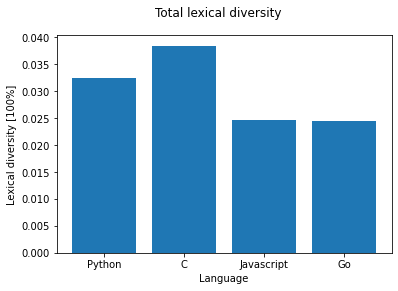

In [145]:
divs = [
    lexical_diversity_whole(df[df['language'] == lang]['normalized_text'])
    for lang in LANGUAGES]

plt.bar(LANGUAGES, divs)
plt.xlabel("Language")
plt.ylabel("Lexical diversity [100%]")
plt.suptitle("Total lexical diversity")
plt.show()


### Average word length

What is the average word length?

C and Golang show a higher average, but the difference is too small to have any statistical significance. The average of slightly above 4 aligns with the english average of 4.7 (source: http://norvig.com/mayzner.html).

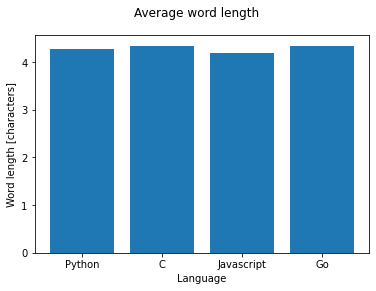

In [153]:
def average_word_length(df: pd.DataFrame, lang: str) -> float:
    lens = []
    for t in df[df['language'] == lang]['tokenized_text']:
        for w in t:
            lens.append(len(w))
            
    return np.mean(lens)


means = [average_word_length(df, lang) for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.xlabel("Language")
plt.ylabel("Word length [characters]")
plt.suptitle("Average word length")
plt.show()


### Percentage of long words

Are longer words more common in different classes?

For the tested lengths, Javascript shows a lower percentage of longer words than other classes. C and Go equally exert a higher frequency of longer words compared to other classes.

In [179]:
def frac_words_over(words: list[str], lang: str, length: int) -> int:
    texts = df[df['language'] == lang]['tokenized_text']
    count = 0
    for t in texts:
        for w in t:
            if len(w) >= length:
                count += 1
            
    return count / texts.apply(len).sum()


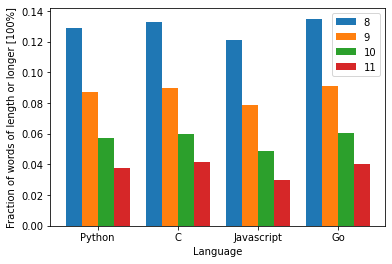

In [180]:
lens = [8, 9, 10, 11]

fracs = [[frac_words_over(df, lang, l) for lang in LANGUAGES] for l in lens]


bar_width = 0.2

for (i, (l, frac)) in enumerate(zip(lens, fracs)):
    plt.bar([x + bar_width*i for x in range(len(LANGUAGES))], frac, width=bar_width, label=l)

plt.xlabel('Language')
plt.ylabel('Fraction of words of length or longer [100%]')
plt.xticks([r + (len(lens)/2 - 0.5) * bar_width for r in range(len(LANGUAGES))], LANGUAGES)
plt.legend()
plt.show()


### Word frequency distribution

Next the most common words are analysed to find some pattern.

In [181]:
from nltk import FreqDist


def get_freq_dist(tokenized_text_series: pd.Series) -> FreqDist:
    return FreqDist(w for text in tokenized_text_series.values for w in text)


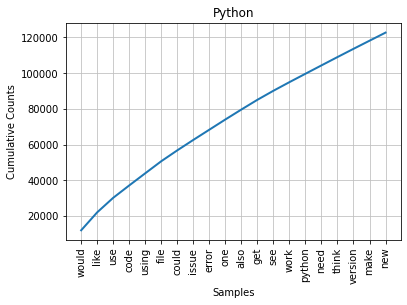

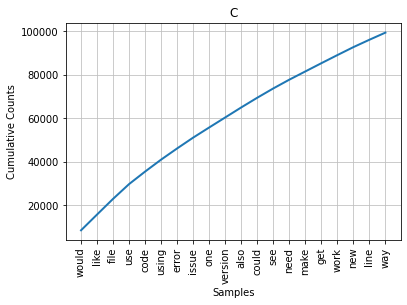

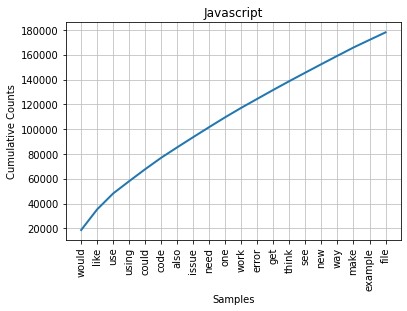

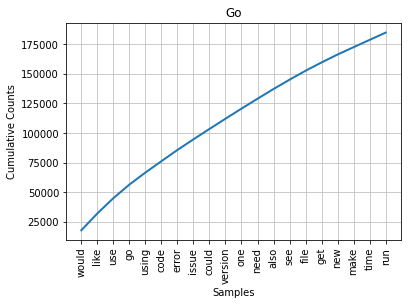

In [182]:
freq_dists = [(lang, get_freq_dist(df[df['language'] == lang]
                                   ['normalized_text'])) for lang in LANGUAGES]

for (lang, dist) in freq_dists:
    dist.plot(20, cumulative=True, title=lang)


It is interesting to note that the word `file` appears much less often in issues posted by Javascript devs in contrast to it being mentioned very often by C devs. This reflects the nature of the languages where C code manipulates files very often while Javascript being constrained to the browser does not have direct access to files. 

Next the commonness of the word `go` in the Golang word is investigated.

In [183]:
def to_nltk_text(df: pd.DataFrame, lang: str) -> nltk.Text:
    return nltk.Text([w for e in df[df['language'] == lang]['normalized_text'] for w in e])

# `go` word is used often by golang developers
go_text = to_nltk_text(df, 'Go')

go_text.concordance("go")


Displaying 25 of 11503 matches:
nning tests works running tests godep go test failes find easy way send health
ders happy work think right direction go currently supported dns provider goog
s menu opened file press debug panels go version download etcd go mod shows er
debug panels go version download etcd go mod shows error package becomed inter
 internal etcd use package vendor use go module imported etcd error thrown ope
o failed valid threw together running go mac needs repl getstreamstohost port 
t many cases gjson makes use standard go package functions carefully uses help
usage also important measures compare go web frameworks add prometheus monitor
kqueue syscalls rather using standard go net package works similar manner libu
 goal project create server framework go performs par redis haproxy packet han
ling hope use foundation future proxy go bunch stuff support write rpcx servic
ally macbook pro ghz intel core using go commands currently nearby command sup
rocess see hi nice w

As we can see above, `go` is used so often due to it being the name of the golang CLI tool. Let's see how many occurrences are actually `go` commands:

In [184]:
def frac_go_subcmd(text: nltk.Text) -> float:
    # Go CLI subcommands as of go v1.18
    subcommands = {'bug', 'build', 'clean', 'doc', 'env', 'fix',
                   'fmt', 'generate', 'get', 'install', 'list',
                   'mod', 'work', 'run', 'test', 'tool', 'version', 'vet'}

    total = 0
    cmds = 0

    for (w1, w2) in nltk.bigrams(text):
        if w1 == 'go':
            if w2 in subcommands:
                cmds += 1
            total += 1
            
    if total == 0:
        return 0

    return (total, cmds / total)

frac_go_subcmd(go_text)

(11503, 0.2950534643136573)

Almost 30% of occurrences of `go` are followed by a subcommand of the Go CLI. Let's see if this relationship is visible in other languages

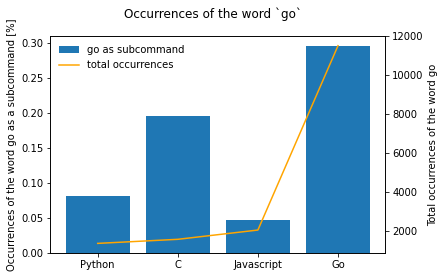

In [185]:
go_subcmd_freq = [frac_go_subcmd(to_nltk_text(df, lang)) for lang in LANGUAGES]

fig, ax1 = plt.subplots()

ax1.bar(LANGUAGES, [t[1] for t in go_subcmd_freq])
ax1.set_ylabel('Occurrences of the word go as a subcommand [%]')
ax1.legend(['go as subcommand'], loc="upper left", frameon=False)

ax2 = ax1.twinx()
ax2.plot([t[0] for t in go_subcmd_freq], color='orange')
ax2.set_ylabel('Total occurrences of the word go')
ax2.legend(['total occurrences'], bbox_to_anchor=(0.395, 0.93), frameon=False)

fig.suptitle('Occurrences of the word `go`')

plt.show()

One can see that Go demonstrates a noticable difference, which explains the often usage of the word 'go' by golang developers. Additionally, golang has a language keyword `go` which runs a function concurrently. This function is at the core of Golang, and is very likely to be discussed often by its developers.

It is interesting to see that even though the usage of the word `go` by C developers is much rarer than by Golang developers, a big chunk of the occurrences (20%) are in the context of a Golang CLI subcommand. Let's check the concordance for the go word in the C language issues.

In [186]:
to_nltk_text(df, 'C').concordance('go')

Displaying 25 of 1566 matches:
ries remotely debugging want actually go network remote locations planes etc r
vents fire store container want reset go back analysis everything stops workin
representation trace arg aliases work go compiled gccgo gccgo hello go gc comp
es work go compiled gccgo gccgo hello go gc compiler go build uses different f
iled gccgo gccgo hello go gc compiler go build uses different function calling
s trace already works expected faster go compiler know added prio low tag wrot
e casting utime different struct llvm go memory consumption program works one 
ry libquic experiments interest using go make build process require code buffe
ing criteria work still met similarly go see project xyz yy completion want ea
isual information users similar maybe go certain threshold would negate answer
erged upstream trees moment show want go reconciling branch upstream versions 
following dependency error make build go build find package goroot gopath find
tadata flip side thou

Mentions of `gccgo` and `cgo` can be noticed. These are respectively the GNU Golang compiler and the C interface for Golang programs. It would seem, that C developers are also Golang developers thus the increase use of the word `go` in the context of the CLI tool.

In [187]:
total_tokens = [np.sum(df[df['language'] == lang]['length'])
                for lang in LANGUAGES]
print(total_tokens)
#Javascript, Python, C: over 40% of text is first 20 words

[3202072, 2772789, 4248497, 4831527]


## Passive sentences frequenccy

Using nltk's part of speach tagger, a given sentence is classified as either passive or not. (Source: https://github.com/flycrane01/nltk-passive-voice-detector-for-English/blob/master/Passive-voice.py)

TODO: what are the conclusions, split into sentences not full text

In [188]:
beforms = ['am', 'is', 'are', 'been', 'was', 'were', 'be', 'being']  # all forms of "be"
aux = ['do', 'did', 'does', 'have', 'has', 'had']


def is_passive(words: list[str]) -> bool:  # NLTK tags "do" and "have" as verbs, which can be misleading in the following section
    tokens = nltk.pos_tag(words)
    tags = [i[1] for i in tokens]
    if tags.count('VBN') == 0:  # no PP, no passive voice.
        return False
    elif tags.count('VBN') == 1 and 'been' in words:  # one PP "been", still no passive voice.
        return False
    else:
        pos = [i for i in range(len(tags)) if
               tags[i] == 'VBN' and words[i] != 'been']  # gather all the PPs that are not "been".
        for end in pos:
            chunk = tags[:end]
            start = 0
            for i in range(len(chunk), 0, -1):
                last = chunk.pop()
                if last == 'NN' or last == 'PRP':
                    start = i  # get the chunk between PP and the previous NN or PRP (which in most cases are subjects)
                    break
            sentchunk = words[start:end]
            tagschunk = tags[start:end]
            verbspos = [i for i in range(len(tagschunk)) if
                        tagschunk[i].startswith('V')]  # get all the verbs in between
            if verbspos != []:  # if there are no verbs in between, it's not passive
                for i in verbspos:
                    if sentchunk[i].lower() not in beforms and sentchunk[
                        i].lower() not in aux:  # check if they are all forms of "be" or auxiliaries such as "do" or "have".
                        break
                else:
                    return True
    return False


In [189]:
def count_passives(texts: pd.Series) -> float:
    count = 0
    for t in texts:
        if is_passive(t):
            count += 1
    return count / len(texts)

In [ ]:
passive_freq = [(lang, count_passives(df[df['language'] == lang]
                                      ['tokenized_text'])) for lang in LANGUAGES]

plt.bar(*zip(*passive_freq))
plt.show()

## Flesch reading score

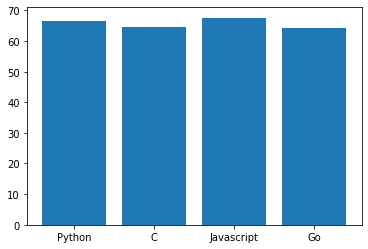

In [24]:
from textstat import textstat

df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)

flesch_reading_score = [(lang, df[df['language'] == lang]['flesch_reading_ease'].mean()) for lang in LANGUAGES]

plt.bar(*zip(*flesch_reading_score))
plt.show()


# Flesch-Kincaid grade

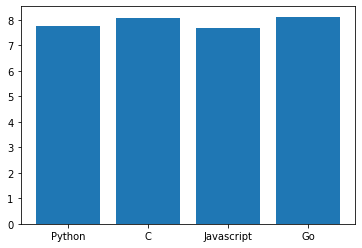

In [26]:
df['flesch_kincaid_grade'] = df['text'].apply(textstat.flesch_kincaid_grade)

flesch_kincaid_grade = [(lang, df[df['language'] == lang]['flesch_kincaid_grade'].mean()) for lang in LANGUAGES]

plt.bar(*zip(*flesch_kincaid_grade))
plt.show()


In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
# df['compound_sentiment'] = df['text'].apply(lambda t: sia.polarity_scores(t)['compound'])
# sia.polarity_scores("Wow, NLTK is really powerful!")

df[df['compound_sentiment'] < -0.8].sample(n=10)['text']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcinwojnarowski/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


55485     Individual commands currently implement their ...
158571    macos high Sierra 10.13.5 xcode 9.3 $ uname -a...
53121     SSL Kill Switch does not seem to work anymore ...
6114      Reported by Jonathan Brannan: When doing 'git ...
167828    Not completely sure what is breaking, and this...
170743    Per the comments in v1beta1 Event: The field c...
43624     As seen in , when the client receives certain ...
20444     Refs We have a bunch of random management comm...
19294     These test failures started with 20.1 beta 3: ...
40555     I have checked the following places for your e...
Name: text, dtype: object